In [23]:
import pandas as pd


Preprocessing

In [32]:
# sample 100 posts and associated comments at random from each subreddit
posts_df_ = pd.read_csv('reddit_posts.csv')
posts_df_['content'] = posts_df_['content'].str.lower()
posts_df_t = posts_df_[(posts_df_['content'].str.contains('trump'))&~(posts_df_['content'].str.contains('biden'))]
posts_df_b = posts_df_[(posts_df_['content'].str.contains('biden'))&~(posts_df_['content'].str.contains('trump'))]

posts_df_ = pd.concat([posts_df_t,posts_df_b])

posts_df = posts_df_[posts_df_['type']=='post'].groupby('subreddit').apply(lambda x: x.sample(100,random_state=1))
posts_df.reset_index(drop=True,inplace=True)


In [36]:
def about_trump_or_biden(text):
    if 'trump' in text:
        return 'trump'
    elif 'biden' in text:
        return 'biden'

posts_df['about_trump_or_biden'] = posts_df['content'].apply(about_trump_or_biden)

In [37]:
posts_df

,content,user,type,subreddit,post_id,about_trump_or_biden
0,carville explains how bad biden throwing over ...,Ask4MD,post,conservative,1aojerv,biden
1,biden raises eyebrows by calling for companies...,gcpanman,post,conservative,1apunbc,biden
2,video: pro-palestinian protester interrupts de...,MackSix,post,conservative,1aqogm1,trump
3,trump is now leading nikki haley by over 80% i...,ivtimescelebs,post,conservative,1ap4xc8,trump
4,biden campaign joins tiktok after admin purged...,asion611,post,conservative,1apindb,biden
...,...,...,...,...,...,...
395,victorious trump says it's time for country to...,intelligentreviews,post,republican,198e2qy,trump
396,haley: ‘irresponsible’ republicans killing bor...,RedBaronsBrother,post,republican,1akdmnm,trump
397,desantis influencers melt down: 'we’re not uni...,cillianmurphy2022,post,republican,19cp7kw,trump
398,mitch mcconnell's bait-and-switch border failu...,intelligentreviews,post,republican,19fktms,trump


Sentiment Analysis

In [39]:
import pandas as pd
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def analyze_sentiment(text):
    try:
        result = sentiment_pipeline(text)
        return result[0]['label'], result[0]['score']
    except Exception as e:
        return "ERROR", None

posts_df[['sentiment', 'score']] = posts_df.apply(lambda row: analyze_sentiment(row['content']), axis=1, result_type='expand')

In [42]:
# count of positive and negative sentiments for trump and biden and for  each subreddit 

counts = posts_df.groupby(['subreddit','about_trump_or_biden','sentiment']).size().unstack(fill_value=0)

counts['TOTAL'] = counts['NEGATIVE'] + counts['POSITIVE']

counts

sentiment                          NEGATIVE  POSITIVE  TOTAL
subreddit    about_trump_or_biden                           
conservative biden                       37        11     48
             trump                       33        19     52
democrats    biden                       26        11     37
             trump                       47        16     63
liberal      biden                       15        11     26
             trump                       56        18     74
republican   biden                       39        11     50
             trump                       35        15     50

Topic Model


In [51]:
# before topic modelling remove stop words and punctuation, and custom words

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stop_words.update(['donald','joe','trump','biden','http','https','www','com','republican','democrat','republicans','democrats','president','election','vote','voting','voted','voter','votes','voters'])
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = word_tokenize(text)
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
    text = ' '.join(text)
    return text

posts_df['cleaned_content'] = posts_df['content'].apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/uditdhand/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
from bertopic import BERTopic

model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = model.fit_transform(posts_df['cleaned_content'])

# Create a DataFrame to hold the topic and probability information
topics_df = pd.DataFrame({
    'topic': topics,
    'probability': [max(prob) if prob.size > 0 else None for prob in probs]
})

# You can now inspect the topics_df DataFrame
print(topics_df.head())



Batches: 100%|██████████| 13/13 [00:00<00:00, 16.83it/s]
2024-02-26 16:29:52,631 - BERTopic - Transformed documents to Embeddings
2024-02-26 16:29:53,834 - BERTopic - Reduced dimensionality
2024-02-26 16:29:53,847 - BERTopic - Clustered reduced embeddings


   topic  probability
0      0     1.000000
1      0     0.590561
2     -1     0.227364
3      0     1.000000
4      2     0.179043


In [80]:
topics_df['topic_name'] = topics_df['topic'].apply(lambda x: model.get_topic_info(x)['Name'])
posts_df['topic'] = topics_df['topic_name']

In [81]:
posts_df

,content,user,type,subreddit,post_id,about_trump_or_biden,sentiment,score,cleaned_content,topic
0,carville explains how bad biden throwing over ...,Ask4MD,post,conservative,1aojerv,biden,NEGATIVE,0.998498,carville explains bad throwing super bowl deep...,0_primary_haley_nikki_gop
1,biden raises eyebrows by calling for companies...,gcpanman,post,conservative,1apunbc,biden,NEGATIVE,0.989316,raise eyebrow calling company stop engaging sh...,0_primary_haley_nikki_gop
2,video: pro-palestinian protester interrupts de...,MackSix,post,conservative,1aqogm1,trump,NEGATIVE,0.997571,video propalestinian protester interrupt tom s...,-1_counsel_white_say_bidens
3,trump is now leading nikki haley by over 80% i...,ivtimescelebs,post,conservative,1ap4xc8,trump,POSITIVE,0.994302,leading nikki haley super tuesday state,0_primary_haley_nikki_gop
4,biden campaign joins tiktok after admin purged...,asion611,post,conservative,1apindb,biden,NEGATIVE,0.993375,campaign join tiktok admin purged app federal ...,2_border_national_impeachment_texas
...,...,...,...,...,...,...,...,...,...,...
395,victorious trump says it's time for country to...,intelligentreviews,post,republican,198e2qy,trump,POSITIVE,0.997346,victorious say time country come together,0_primary_haley_nikki_gop
396,haley: ‘irresponsible’ republicans killing bor...,RedBaronsBrother,post,republican,1akdmnm,trump,NEGATIVE,0.947469,haley ‘ irresponsible ’ killing border bill he...,2_border_national_impeachment_texas
397,desantis influencers melt down: 'we’re not uni...,cillianmurphy2022,post,republican,19cp7kw,trump,NEGATIVE,0.999400,desantis influencers melt ’ uniting behind,0_primary_haley_nikki_gop
398,mitch mcconnell's bait-and-switch border failu...,intelligentreviews,post,republican,19fktms,trump,NEGATIVE,0.980633,mitch mcconnells baitandswitch border failure ...,2_border_national_impeachment_texas


In [101]:
# count of topic wise posts , sentiment wise, trump or biden wise, subreddit wise

counts = posts_df.groupby(['subreddit','about_trump_or_biden','sentiment','topic']).size().unstack(fill_value=0)
#
counts

topic                                        -1_counsel_white_say_bidens  \
subreddit    about_trump_or_biden sentiment                                
conservative biden                NEGATIVE                            16   
                                  POSITIVE                             6   
             trump                NEGATIVE                             6   
                                  POSITIVE                             3   
democrats    biden                NEGATIVE                             9   
                                  POSITIVE                             4   
             trump                NEGATIVE                            10   
                                  POSITIVE                             3   
liberal      biden                NEGATIVE                             3   
                                  POSITIVE                             3   
             trump                NEGATIVE                            14   
                                  POSITIVE                             7   
republican   biden                NEGATIVE                            11   
                                  POSITIVE                             3   
             trump                NEGATIVE                             9   
                                  POSITIVE                             3   

topic                                        0_primary_haley_nikki_gop  \
subreddit    about_trump_or_biden sentiment                              
conservative biden                NEGATIVE                           3   
                                  POSITIVE                           1   
             trump                NEGATIVE                           6   
                                  POSITIVE                           3   
democrats    biden                NEGATIVE                           3   
                                  POSITIVE                           3   
             trump                NEGATIVE                           7   
                                  POSITIVE                           1   
liberal      biden                NEGATIVE                           1   
                                  POSITIVE                           3   
             trump                NEGATIVE                           7   
                                  POSITIVE                           4   
republican   biden                NEGATIVE                           5   
                                  POSITIVE                           1   
             trump                NEGATIVE                           9   
                                  POSITIVE                          10   

topic                                        1_people_poll_say_america  \
subreddit    about_trump_or_biden sentiment                              
conservative biden                NEGATIVE                           9   
                                  POSITIVE                           1   
             trump                NEGATIVE                           1   
                                  POSITIVE                           3   
democrats    biden                NEGATIVE                           3   
                                  POSITIVE                           3   
             trump                NEGATIVE                           3   
                                  POSITIVE                           5   
liberal      biden                NEGATIVE                           7   
                                  POSITIVE                           2   
             trump                NEGATIVE                          16   
                                  POSITIVE                           4   
republican   biden                NEGATIVE                           2   
                                  POSITIVE                           2   
             trump                NEGATIVE                           2   
                                  POSITI

Network

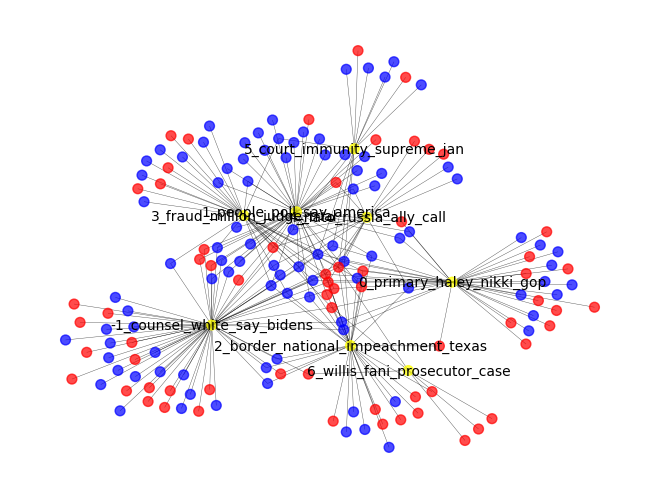

In [164]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

avg_sentiment = posts_df.groupby(['topic', 'user'])['score'].mean().reset_index()

edges = [(row['user'], row['topic'], row['score']) for index, row in avg_sentiment.iterrows()]

user_subreddit = posts_df[['user', 'subreddit']].drop_duplicates().set_index('user')['subreddit'].to_dict()
topic_nodes = avg_sentiment['topic'].unique()
user_nodes = avg_sentiment['user'].unique()

color_map = {'republican': 'red', 'democrats': 'blue', 'liberal': 'blue', 'conservative': 'red'}
node_color_map = {**{topic: 'yellow' for topic in topic_nodes}, **color_map}  # Assuming topics have a default color, e.g., 'yellow'
all_nodes = list(topic_nodes) + list(user_nodes)
node_colors = [node_color_map[user_subreddit.get(user, 'default')] if user in user_nodes else 'yellow' for user in all_nodes]
B = nx.Graph()
B.add_nodes_from(topic_nodes, bipartite=0)
B.add_nodes_from(user_nodes, bipartite=1)
B.add_weighted_edges_from(edges)

pos = nx.spring_layout(B)

nx.draw(B, pos, with_labels=False, node_color=node_colors, edge_color='black', node_size=50, font_size=3, edge_cmap=plt.cm.Blues, width=0.3, alpha=0.7)

# label only topics
topic_nodes = {node: node for node in topic_nodes}
nx.draw_networkx_labels(B, pos, labels=topic_nodes, font_size=10)
plt.show()


In [167]:
# centrality measures of the topics:

degree_centrality = nx.degree_centrality(B)
closeness_centrality = nx.closeness_centrality(B)
betweenness_centrality = nx.betweenness_centrality(B)

centrality_measures = pd.DataFrame({
    'topic': list(degree_centrality.keys()),
    'degree_centrality': list(degree_centrality.values()),
    'closeness_centrality': list(closeness_centrality.values()),
    'betweenness_centrality': list(betweenness_centrality.values())
})

centrality_measures.sort_values(by='betweenness_centrality', ascending=False).head(10)

,topic,degree_centrality,closeness_centrality,betweenness_centrality
0,-1_counsel_white_say_bidens,0.367470,0.449864,0.441487
2,1_people_poll_say_america,0.283133,0.418136,0.319622
1,0_primary_haley_nikki_gop,0.228916,0.400000,0.264230
3,2_border_national_impeachment_texas,0.198795,0.390588,0.194978
4,3_fraud_million_judge_trial,0.168675,0.381609,0.172155
51,intelligentreviews,0.048193,0.512346,0.116887
6,5_court_immunity_supreme_jan,0.078313,0.356989,0.087823
5,4_nato_russia_ally_call,0.096386,0.361656,0.076354
43,Walk1000Miles,0.036145,0.482558,0.073226
52,interestingfactoid,0.030120,0.412935,0.039833


In [240]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import community as community_louvain  # This library is often called python-louvain

# Assuming you have your posts_df DataFrame from the previous context
avg_sentiment = posts_df.groupby(['topic', 'user'])['score'].mean().reset_index()

edges = [(row['user'], row['topic'], row['score']) for index, row in avg_sentiment.iterrows()]

user_subreddit = posts_df[['user', 'subreddit']].drop_duplicates().set_index('user')['subreddit'].to_dict()
topic_nodes = avg_sentiment['topic'].unique()
user_nodes = avg_sentiment['user'].unique()

B = nx.Graph()
B.add_nodes_from(topic_nodes, bipartite=0)
B.add_nodes_from(user_nodes, bipartite=1)
B.add_weighted_edges_from(edges)

# Detecting communities
partition = community_louvain.best_partition(B)

# Printing users in each community
for community_id in set(partition.values()):
    print(f"Community {community_id}:")
    members = [node for node, community in partition.items() if community == community_id and node in user_nodes]
    print(members)


Community 0:
['Agitated-Fortune6162', 'Beliavsky', 'BruceCampbell123', 'CharmCityCrab', 'ChineseGoddess', 'Content-Carpenter833', 'DEMOCREPUBLIX', 'Desperate_Wafer_8566', 'DogfaceDino', 'Flat_Pomelo_6605', 'GameOfShadows', 'Jaybee20251', 'JimCripe', 'Josiah-White', 'MackSix', 'Maryland_Bear', 'Maxcactus', 'MuffMagician', 'Multigrain_Migraine', 'Raspberries-Are-Evil', 'Shifty-R0ckwell', 'anujtomar_17', 'davidreiss666', 'herequeerandgreat', 'jonfla', 'roundearthervaxxer', 'snaggletoothdotcom', 'spaced_out_will', 'starryinc', 'summer-of-1917', 'thorvard', 'varg_ballerina', 'worlddestruction23']
Community 1:
['Doom_Walker', 'ivtimescelebs', 'myvisionvivid', '2KALUBAFAK40z', 'BaudiIROCZ', 'DiegoTukma', 'EgoDefenseMechanism', 'GFYS2025', 'JFedkiw', 'MicahWeeks', 'OpportunityDefiant31', 'PsychologicalBell516', 'Randomlynumbered', 'Specialist-Switch-15', 'Trump4ever8', 'crunrun', 'dizzyhitman_007', 'gcpanman', 'hrothen1', 'livinginbizzaroworld', 'my_vision_vivid', 'patriotsprime', 'politicalth

In [250]:
# now find affiliation of each community with trump or biden


for community_id in set(partition.values()):
    members = [node for node, community in partition.items() if community == community_id and node in user_nodes]
    community_affiliation[community_id] = posts_df[posts_df['user'].isin(members)]['subreddit'].value_counts().idxmax()

community_affiliation



{0: 'democrats',
 1: 'liberal',
 2: 'liberal',
 3: 'republican',
 4: 'democrats',
 5: 'conservative',
 6: 'liberal',
 7: 'republican'}

In [254]:
# what are the differences between 3  'liberal' communities that got detected?

liberal_communities = [community_id for community_id, affiliation in community_affiliation.items() if affiliation=='republican']

for community_id in liberal_communities:
    members = [node for node, community in partition.items() if community == community_id and node in user_nodes]
    print(f"Community {community_id}:")
    print(posts_df[posts_df['user'].isin(members)]['topic'].value_counts().head(5))
    print("\n")



Community 3:
topic
2_border_national_impeachment_texas    26
1_people_poll_say_america               7
-1_counsel_white_say_bidens             6
0_primary_haley_nikki_gop               2
3_fraud_million_judge_trial             1
Name: count, dtype: int64


Community 7:
topic
-1_counsel_white_say_bidens            23
2_border_national_impeachment_texas    21
0_primary_haley_nikki_gop              15
6_willis_fani_prosecutor_case          12
3_fraud_million_judge_trial             4
Name: count, dtype: int64


